In [283]:
from rfgap import RFGAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import dataprep
from phate import PHATE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [284]:
# Read in and prepare the data

data_name = 'treeData'
save_figs = False


data   = pd.read_csv('../datasets/' + data_name + '.csv', sep = ',')
x, y   = dataprep(data, scale = None)
n, d   = x.shape
n_classes = len(y.unique())

x_train, x_test, y_train, y_test, inds_train, inds_test = train_test_split(x, y, np.arange(n), test_size=0.1, random_state = 42)

n_test = x_test.shape[0]

In [285]:
# Random forest on all data for PHATE embedding visualization
rfphate = RFGAP(oob_score = True, non_zero_diagonal = True, random_state = 42)
rfphate.fit(x, y)
prox_phate = rfphate.get_proximities()

In [286]:
# Random forest for uncertainty measures; using split datasets
rf = RFGAP(oob_score = True, random_state = 42)
rf.fit(x_train, y_train)
prox = rf.get_proximities()

In [287]:
# Generate OOB and Test trust scores
trust_scores_oob = rf.get_trust_scores()
trust_scores_test = rf.get_test_trust(x_test)

Currently minus not taking oob_correct into account


In [288]:
def reverse_scale_sklearn(x, min_size = 5, max_size = 100):
    scaler = MinMaxScaler(feature_range = (min_size, max_size))

    return max_size - scaler.fit_transform(x) + min_size

In [289]:
# Helper functions for plots
def reverse_scale(x, min_size = 5, max_size = 100, log_scale = False):
    
    if log_scale:
        x = np.log(x + np.finfo(np.float64).eps)
        x_scaled = max_size - (x - x.min())/(x.max() - x.min()) * max_size + min_size
    else:
        x_scaled = max_size - (x - x.min())/(x.max() - x.min()) * max_size + min_size

    return x_scaled

In [324]:
# RF-PHATE embedding for scatterplots
phate_op = PHATE(knn_dist = 'precomputed', verbose = 0)
emb = phate_op.fit_transform(prox_phate)

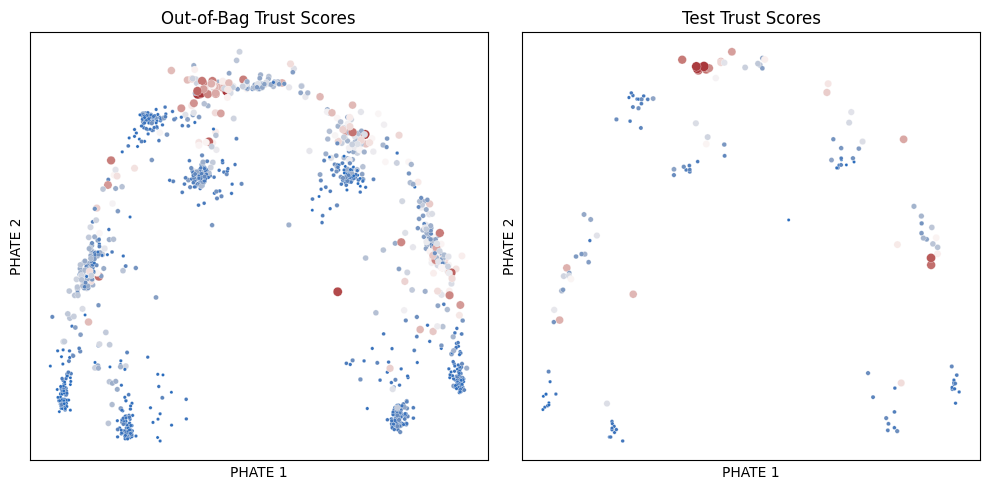

In [291]:
# RF-PHATE train/test plots
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
plt.subplots_adjust(hspace = 0.5, wspace = 0.1)
color_palette = sns.color_palette('vlag', as_cmap = True)


min_size = 5
max_size = 50

hue_norm = (min_size, max_size)

oob_scale = reverse_scale(trust_scores_oob, min_size = min_size, max_size = max_size)
test_scale = reverse_scale(trust_scores_test, min_size = min_size, max_size = max_size)

sns.scatterplot(ax = axes[0], x = emb[inds_train, 0], y = emb[inds_train, 1],
                hue = oob_scale, 
                hue_norm = hue_norm,
                size = oob_scale,
                sizes = (min_size, max_size),
                palette = color_palette)


sns.scatterplot(ax = axes[1], x = emb[inds_test, 0], y = emb[inds_test, 1],
                hue = test_scale, 
                hue_norm = hue_norm,
                size = test_scale,
                sizes = (min_size, max_size),
                palette = color_palette)


axes[0].set_title('Out-of-Bag Trust Scores')
axes[1].set_title('Test Trust Scores')

for ax in axes:
    ax.set_xlabel('PHATE 1')
    ax.set_ylabel('PHATE 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend([], [], frameon = False)


plt.tight_layout()

if save_figs:
    plt.savefig('./figures/' + data_name + '_trust_scores_oob_test.pdf')

In [292]:
# Get trust score quantiles for both OOB and Test points
oob_trust_quantiles = rf.trust_quantiles
test_trust_quantiles = rf.trust_quantiles_test

In [293]:
# The number of points dropped based on low trust quantiles
n_oob_dropped = []
n_test_dropped = []

for q in oob_trust_quantiles:
    n_oob_dropped.append(np.sum(trust_scores_oob < q))
n_oob_dropped = np.array(n_oob_dropped)

for q in oob_trust_quantiles:
    n_test_dropped.append(np.sum(trust_scores_test < q))
n_test_dropped = np.array(n_test_dropped)

In [294]:
print(len(n_oob_dropped))
print(len(n_test_dropped))

print(len(oob_trust_quantiles))
print(len(test_trust_quantiles))

100
100
100
100


In [295]:
def nearest_value_index(arr, value):
    return np.argmin(np.abs(arr - value))

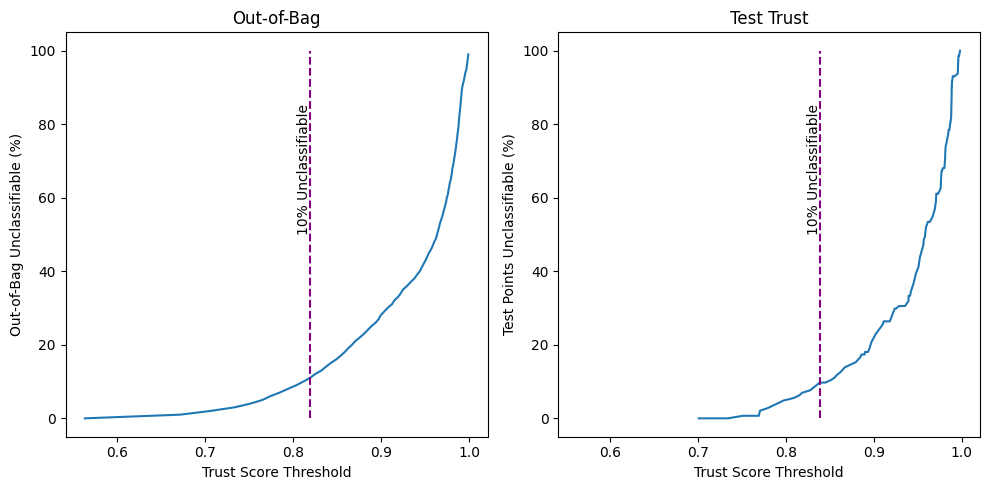

In [330]:
# Plot of test  and oob trust score quantiles
fig, axes = plt.subplots(1, 2, figsize = (10, 5), sharex=True)


sns.lineplot(ax = axes[0], x = oob_trust_quantiles, y = n_oob_dropped / len(y_train) * 100)
sns.lineplot(ax = axes[1], x = test_trust_quantiles, y = n_test_dropped / len(y_test) * 100)

# Vertical Lines
axes[0].vlines(x = oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)], color = 'purple', linestyle = '--',
               ymin = 0, ymax = 100)

axes[0].text(oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)] - 0.015, 50, '10% Unclassifiable', rotation=90, verticalalignment='bottom')

axes[1].vlines(x = test_trust_quantiles[nearest_value_index(np.round(n_test_dropped / n_test, 2), 0.1)], color = 'purple', linestyle = '--',
               ymin = 0, ymax = 100)

axes[1].text(test_trust_quantiles[nearest_value_index(np.round(n_test_dropped / n_test, 2), 0.1)] - 0.015, 50, '10% Unclassifiable', rotation=90, verticalalignment='bottom')

# Horizontal Lines
# Horizontal Lines
# x_value = oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)]
# y_value = np.interp(x_value, oob_trust_quantiles, np.round(n_oob_dropped / n, 2) * 100)
# axes[0].hlines(y = y_value, xmin = np.min(oob_trust_quantiles), xmax = x_value, color = 'green', linestyle = '--')
# axes[0].text(np.min(oob_trust_quantiles), y_value, f'Pct. Unclassifiable: {y_value:.2f}', verticalalignment='bottom')

# x_value = test_trust_quantiles[np.where(np.round(n_test_dropped / n_test, 2) == 0.1)]
# y_value = np.interp(x_value, test_trust_quantiles, np.round(n_test_dropped / n_test, 2) * 100)
# axes[1].hlines(y = y_value, xmin = np.min(test_trust_quantiles), xmax = x_value, color = 'green', linestyle = '--')
# axes[1].text(np.min(test_trust_quantiles), y_value, f'Accuracy: {y_value:.2f}', verticalalignment='bottom')



axes[0].set_title('Out-of-Bag')
axes[0].set_ylabel('Out-of-Bag Unclassifiable (%)')
axes[0].set_xlabel('Trust Score Threshold')

axes[1].set_title('Test Trust')
axes[1].set_ylabel('Test Points Unclassifiable (%)')
axes[1].set_xlabel('Trust Score Threshold')

plt.tight_layout()

if save_figs:
    plt.savefig('./figures/' + data_name + '_pct_dropped.pdf')

In [297]:
# Check accuracy after dropping unclassifiable points
oob_drop_accuracy = []
test_drop_accuracy = []

oob_prop_misclass_dropped = []
test_prop_misclass_dropped = []

for q in oob_trust_quantiles:

    idx_temp = trust_scores_oob >= q
    idx_temp_test = trust_scores_test >= q

    oob_preds = np.argmax(rf.oob_decision_function_, axis = 1)[idx_temp]
    dropped_oob_preds = np.argmax(rf.oob_decision_function_, axis = 1)[~idx_temp]

    oob_drop_accuracy.append(np.mean(y_train[idx_temp] == oob_preds))

    try:
        test_drop_accuracy.append(np.mean(y_test[idx_temp_test] == rf.predict(x_test[idx_temp_test])))

    except:
        test_drop_accuracy.append(1)

    # Add proportion of misclassified points dropped

    oob_prop_misclass_dropped.append(np.mean(y_train[~idx_temp] != dropped_oob_preds))

    try:
        test_prop_misclass_dropped.append(np.mean(y_test[~idx_temp_test] != rf.predict(x_test[~idx_temp_test])))
    except:
        test_prop_misclass_dropped.append(0) # CHECK TO SEE IF THIS MAKES SENSE



oob_drop_accuracy = np.array(oob_drop_accuracy)
test_drop_accuracy = np.array(test_drop_accuracy)

oob_prop_misclass_dropped = np.array(oob_prop_misclass_dropped)
test_prop_misclass_dropped = np.array(test_prop_misclass_dropped)

In [333]:
oob_drop_accuracy

array([0.93904321, 0.93920499, 0.94330709, 0.94431185, 0.94694534,
       0.9488221 , 0.95073892, 0.95352697, 0.95637584, 0.95759118,
       0.95797599, 0.95923677, 0.96315789, 0.96450754, 0.96499102,
       0.96730245, 0.96966912, 0.97023256, 0.97363465, 0.9742612 ,
       0.97492768, 0.98046875, 0.98120673, 0.98496994, 0.9857868 ,
       0.98559671, 0.98540146, 0.98731501, 0.98928189, 0.99021739,
       0.99007718, 0.99105145, 0.99205448, 0.99308756, 0.99298246,
       0.99287411, 0.99396864, 0.99387255, 0.99501868, 0.99493671,
       0.99614396, 0.99738562, 0.99734043, 0.99729364, 0.99724518,
       0.99719495, 0.99714286, 0.99708879, 0.99703264, 0.99697428,
       0.99691358, 0.99685039, 0.99678457, 0.99835796, 0.99832215,
       0.99828473, 0.99824561, 0.99820467, 0.99816176, 0.99811676,
       0.99807322, 0.99802372, 0.9979716 , 0.99791667, 0.99785867,
       0.99779736, 0.99773243, 0.99766355, 0.99759036, 0.99751244,
       0.99742931, 1.        , 1.        , 1.        , 1.     

In [334]:
oob_trust_quantiles

array([0.56318156, 0.67162244, 0.70585783, 0.73356795, 0.75140353,
       0.76515216, 0.77382619, 0.78472697, 0.79398482, 0.80368068,
       0.81174588, 0.81914257, 0.82490351, 0.83221142, 0.8371927 ,
       0.84257172, 0.84895507, 0.85399823, 0.85854991, 0.86239048,
       0.86667762, 0.87042863, 0.87563173, 0.88030306, 0.88441689,
       0.88852576, 0.89351847, 0.89715693, 0.89925603, 0.90321785,
       0.9072318 , 0.91206355, 0.91472939, 0.91898875, 0.92225028,
       0.92474611, 0.92936698, 0.9332166 , 0.9376298 , 0.94056553,
       0.94365952, 0.94590944, 0.94800446, 0.95032385, 0.95223758,
       0.95409879, 0.95667607, 0.95857478, 0.96016139, 0.96233384,
       0.96340535, 0.96452754, 0.96566379, 0.96667325, 0.96807126,
       0.96941953, 0.97051325, 0.97167553, 0.97279425, 0.97381557,
       0.97445682, 0.97566399, 0.97634437, 0.9771457 , 0.97785615,
       0.97898454, 0.97971073, 0.98041584, 0.98080712, 0.981776  ,
       0.98243597, 0.98319502, 0.98380537, 0.98445733, 0.98501

In [337]:
np.linspace(0, .99, 100)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

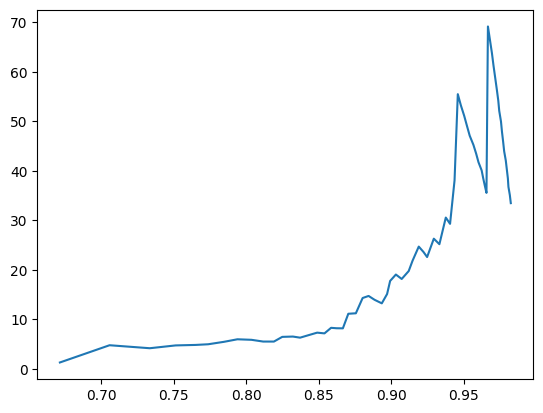

In [298]:
misclass_ratios = oob_prop_misclass_dropped[oob_drop_accuracy < 1] / (1 - oob_drop_accuracy[oob_drop_accuracy < 1])
plt.plot(oob_trust_quantiles[oob_drop_accuracy < 1], misclass_ratios)

C:\Users\rhodes8\AppData\Local\Temp\ipykernel_31380\2230869813.py:1: RuntimeWarning: divide by zero encountered in divide
  misclass_ratios_test = test_prop_misclass_dropped / (1 - test_drop_accuracy)


Text(0, 0.5, 'Ratio: Misclassified Dropped / Not Dropped')

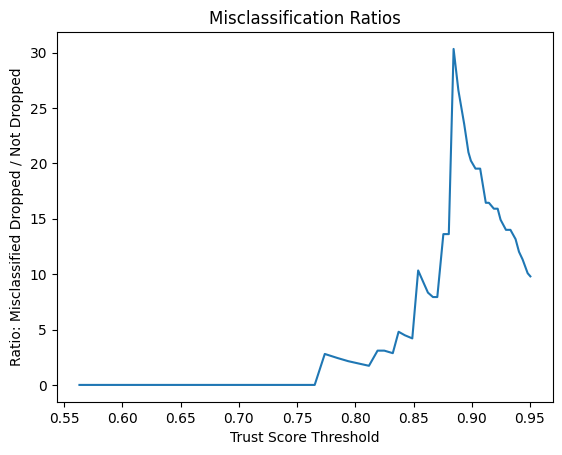

In [299]:
misclass_ratios_test = test_prop_misclass_dropped / (1 - test_drop_accuracy)
plt.plot(oob_trust_quantiles, misclass_ratios_test)
plt.title('Misclassification Ratios')
plt.xlabel('Trust Score Threshold')
plt.ylabel('Ratio: Misclassified Dropped / Not Dropped')

# That is, the higher the trust score, the more likely the model is to misclassify the dropped points

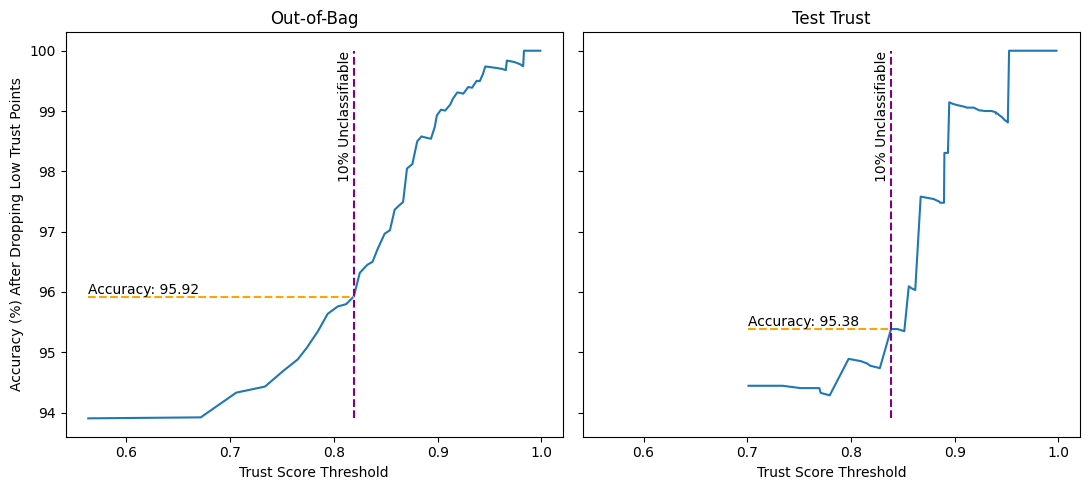

In [329]:
fig, axes = plt.subplots(1, 2, figsize = (11, 5), sharey = True, sharex = True)
plt.subplots_adjust(hspace = 0.5, wspace = 0.1)

sns.lineplot(ax = axes[0], x = oob_trust_quantiles, y = oob_drop_accuracy * 100)
sns.lineplot(ax = axes[1], x = test_trust_quantiles, y = test_drop_accuracy * 100)


axes[0].vlines(x = oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)], color = 'purple', linestyle = '--',
               ymin = np.min(oob_drop_accuracy) * 100, ymax = 100)

axes[1].vlines(x = test_trust_quantiles[nearest_value_index(np.round(n_test_dropped / n_test, 2), 0.1)], color = 'purple', linestyle = '--',
               ymin = np.min(oob_drop_accuracy) * 100, ymax = 100)

axes[0].text(oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)] - 0.015, 100, '10% Unclassifiable', rotation=90, verticalalignment='top')
axes[1].text(test_trust_quantiles[nearest_value_index(np.round(n_test_dropped / n_test, 2), 0.1)] - 0.015, 100, '10% Unclassifiable', rotation=90, verticalalignment='top')

# Horizontal Lines
x_value = oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)]
y_value = np.interp(x_value, oob_trust_quantiles, oob_drop_accuracy * 100)
axes[0].hlines(y = y_value, xmin = np.min(oob_trust_quantiles), xmax = x_value, color = 'orange', linestyle = '--')
axes[0].text(np.min(oob_trust_quantiles), y_value, f'Accuracy: {y_value:.2f}', verticalalignment='bottom')

x_value = test_trust_quantiles[nearest_value_index(np.round(n_test_dropped / n_test, 2), 0.1)]
y_value = np.interp(x_value, test_trust_quantiles, test_drop_accuracy * 100)
axes[1].hlines(y = y_value, xmin = np.min(test_trust_quantiles), xmax = x_value, color = 'orange', linestyle = '--')
axes[1].text(np.min(test_trust_quantiles), y_value, f'Accuracy: {y_value:.2f}', verticalalignment='bottom')

axes[0].set_title('Out-of-Bag')
axes[0].set_ylabel('Accuracy (%) After Dropping Low Trust Points')
axes[0].set_xlabel('Trust Score Threshold')

axes[1].set_title('Test Trust')
axes[1].set_xlabel('Trust Score Threshold')

plt.tight_layout()

if save_figs:
    plt.savefig('./figures/' + data_name + '_accuracy_after_dropped.pdf')

In [301]:
rffull = RFGAP(oob_score = True, random_state = 42)
rffull.fit(x, y)
full_trust_scores = rffull.get_trust_scores()

Currently minus not taking oob_correct into account


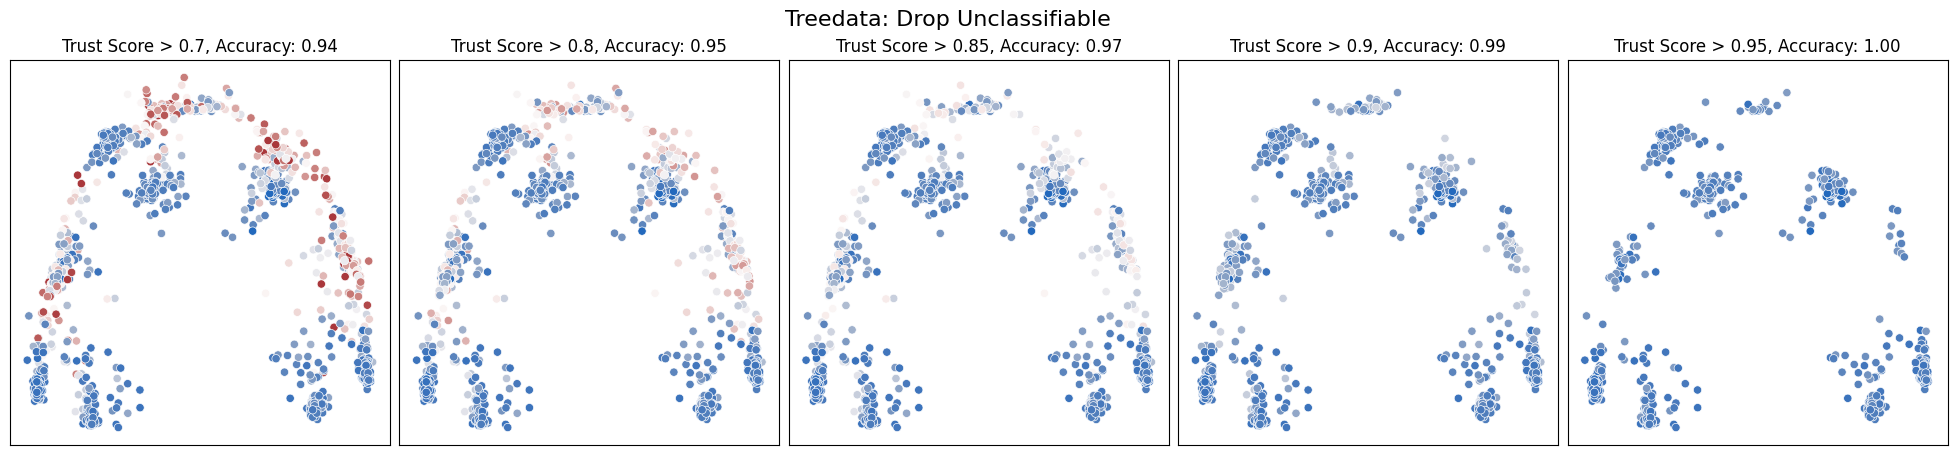

In [302]:
qs = [0.7, 0.8, 0.85, 0.9, 0.95]

fig, axes = plt.subplots(1, 5, figsize = (25, 5), sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.5, wspace = 0.025)
color_palette = sns.color_palette('vlag', as_cmap = True)

# Define size and colormap outside the loop
size = reverse_scale(full_trust_scores)
colormap = reverse_scale(full_trust_scores)
hue_norm = (int(np.min(colormap)), int(np.quantile(colormap, 0.97)))

for i, ax in enumerate(axes.ravel()):

    q = qs[i]
    idx_temp = full_trust_scores > q
    oob_preds = np.argmax(rffull.oob_decision_function_, axis = 1)[idx_temp]

    sns.scatterplot(ax = ax, x = emb[idx_temp, 0], y = emb[idx_temp, 1],
                    hue = colormap[idx_temp],
                    hue_norm = hue_norm,
                    sizes = size[idx_temp],
                    palette = color_palette,
                    legend = False)  # Disable legend for each subplot
    
    ax.set_title(f'Trust Score > {q}, Accuracy: {np.mean(y[idx_temp] == oob_preds):.2f}')
    ax.set_xticks([])
    ax.set_yticks([])   

fig.suptitle(str.title(data_name) + ': Drop Unclassifiable', fontsize=16)

if save_figs:
    plt.savefig('./figures/' + data_name + '_trust_scores_sequence.png')

In [323]:
phate_op = PHATE(t = 150, gamma = 0, verbose = 0)
phate_emb = phate_op.fit_transform(x)

Text(0.5, 0.98, 'Treedata: Drop Unclassifiable')

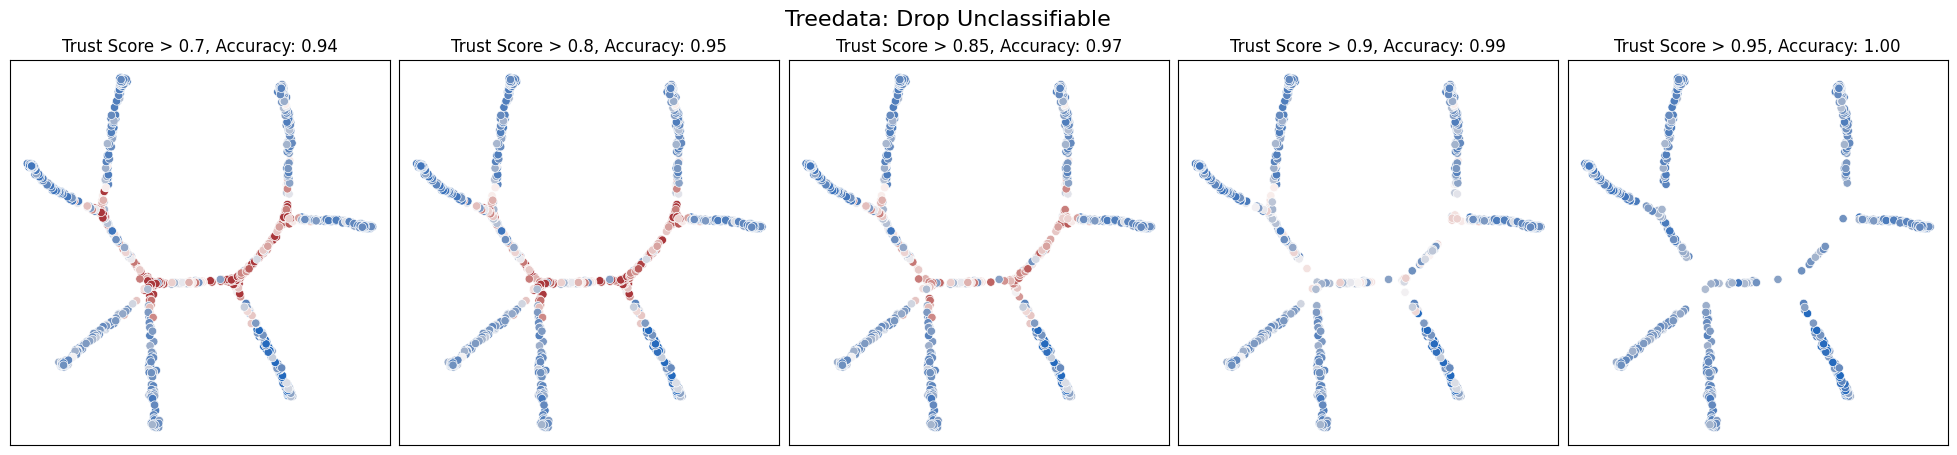

In [322]:
qs = [0.7, 0.8, 0.85, 0.9, 0.95]

fig, axes = plt.subplots(1, 5, figsize = (25, 5), sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.5, wspace = 0.025)
color_palette = sns.color_palette('vlag', as_cmap = True)

# Define size and colormap outside the loop
size = reverse_scale(full_trust_scores)
colormap = reverse_scale(full_trust_scores)
hue_norm = (int(np.min(colormap)), int(np.quantile(colormap, 0.85)))

for i, ax in enumerate(axes.ravel()):

    q = qs[i]
    idx_temp = full_trust_scores > q
    oob_preds = np.argmax(rffull.oob_decision_function_, axis = 1)[idx_temp]

    sns.scatterplot(ax = ax, x = phate_emb[idx_temp, 0], y = phate_emb[idx_temp, 1],
                    hue = colormap[idx_temp],
                    hue_norm = hue_norm,
                    sizes = size[idx_temp],
                    palette = color_palette,
                    legend = False)  # Disable legend for each subplot
    
    ax.set_title(f'Trust Score > {q}, Accuracy: {np.mean(y[idx_temp] == oob_preds):.2f}')
    ax.set_xticks([])
    ax.set_yticks([])   

fig.suptitle(str.title(data_name) + ': Drop Unclassifiable', fontsize=16)

In [357]:

# Table of results
quantiles_table = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
oob_trust_quantiles_table = np.quantile(trust_scores_oob, quantiles_table)
dataset_name_table = np.repeat(data_name, len(quantiles_table))
oob_drop_accuracy_table = oob_drop_accuracy[[int(quantile * 100) for quantile in quantiles_table]]
n_oob_dropped_table = n_oob_dropped[[int(quantile * 100) for quantile in quantiles_table]]
oob_accuracy_table = np.repeat(rf.oob_score_, len(quantiles_table))
accuracy_diff_table = oob_drop_accuracy_table - oob_accuracy_table

# Headers

headers = ['Dataset', 'Trust Quantile', 'OOB Trust Score', 'OOB Accuracy', 'OOB Accuracy After Drop', 'OOB Dropped (%)', 'Accuracy Diff (%)']

table = pd.DataFrame(np.vstack([dataset_name_table, quantiles_table, oob_trust_quantiles_table, oob_accuracy_table, oob_drop_accuracy_table, n_oob_dropped_table / n, accuracy_diff_table]).T, columns = headers)


In [358]:
table

,Dataset,Trust Quantile,OOB Trust Score,OOB Accuracy,OOB Accuracy After Drop,OOB Dropped (%),Accuracy Diff (%)
0,treeData,0.5,0.9634053505805931,0.9390432098765432,0.9969135802469136,0.45,0.05787037037037035
1,treeData,0.55,0.9694195280417442,0.9390432098765432,0.9982847341337907,0.4951388888888889,0.05924152425724749
2,treeData,0.6,0.9744568211893412,0.9390432098765432,0.9980732177263969,0.5395833333333333,0.05903000784985368
3,treeData,0.65,0.9789845378188103,0.9390432098765432,0.9977973568281938,0.5847222222222223,0.0587541469516506
4,treeData,0.7,0.9824359657410088,0.9390432098765432,0.9974293059125964,0.6298611111111111,0.05838609603605316
5,treeData,0.75,0.9854964173007434,0.9390432098765432,1.0,0.675,0.06095679012345678
6,treeData,0.8,0.9879907713410238,0.9390432098765432,1.0,0.7194444444444444,0.06095679012345678
7,treeData,0.85,0.9899523146066886,0.9390432098765432,1.0,0.7645833333333333,0.06095679012345678
8,treeData,0.9,0.9919939284065762,0.9390432098765432,1.0,0.8097222222222222,0.06095679012345678
9,treeData,0.95,0.9967677748582107,0.9390432098765432,1.0,0.8548611111111111,0.06095679012345678


In [355]:
accuracy_diff_table

array([0.05787037, 0.05924152, 0.05903001, 0.05875415, 0.0583861 ,
       0.06095679, 0.06095679, 0.06095679, 0.06095679, 0.06095679])

In [348]:
oob_drop_accuracy

array([0.93904321, 0.93920499, 0.94330709, 0.94431185, 0.94694534,
       0.9488221 , 0.95073892, 0.95352697, 0.95637584, 0.95759118,
       0.95797599, 0.95923677, 0.96315789, 0.96450754, 0.96499102,
       0.96730245, 0.96966912, 0.97023256, 0.97363465, 0.9742612 ,
       0.97492768, 0.98046875, 0.98120673, 0.98496994, 0.9857868 ,
       0.98559671, 0.98540146, 0.98731501, 0.98928189, 0.99021739,
       0.99007718, 0.99105145, 0.99205448, 0.99308756, 0.99298246,
       0.99287411, 0.99396864, 0.99387255, 0.99501868, 0.99493671,
       0.99614396, 0.99738562, 0.99734043, 0.99729364, 0.99724518,
       0.99719495, 0.99714286, 0.99708879, 0.99703264, 0.99697428,
       0.99691358, 0.99685039, 0.99678457, 0.99835796, 0.99832215,
       0.99828473, 0.99824561, 0.99820467, 0.99816176, 0.99811676,
       0.99807322, 0.99802372, 0.9979716 , 0.99791667, 0.99785867,
       0.99779736, 0.99773243, 0.99766355, 0.99759036, 0.99751244,
       0.99742931, 1.        , 1.        , 1.        , 1.     

In [340]:
quantiles_table * 100

array([50., 55., 60., 65., 70., 75., 80., 85., 90., 95.])